# Recommendation System

This session we will do the 
[Collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering)
using the [Movielens dataset](https://www.kaggle.com/c/movielens-100k)
to recommend movies to users.
The MovieLens ratings dataset lists the ratings given by a set of users to a set of movies.
Our goal is to be able to predict ratings for movies a user has not yet watched.
The movies with the highest predicted ratings can then be recommended to the user.

In [13]:
import os
import math
import pandas as pd
import numpy as np
from zipfile import ZipFile
from urllib.request import urlretrieve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt


Data download

In [2]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)


983040/978202 [==============================] - 4s 4us/step
Extracting all the files now...
Done!


preprocessing to encode users and movies as integer

In [3]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)


Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


Prepare training and validation data

In [4]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)


Create model

In [6]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001)
)


Train the model

In [7]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)


Epoch 1/5
1418/1418 [==============================] - 12s 7ms/step - loss: 0.6361 - val_loss: 0.6203
Epoch 2/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6133 - val_loss: 0.6183
Epoch 3/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6084 - val_loss: 0.6166
Epoch 4/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6072 - val_loss: 0.6147
Epoch 5/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6064 - val_loss: 0.6126


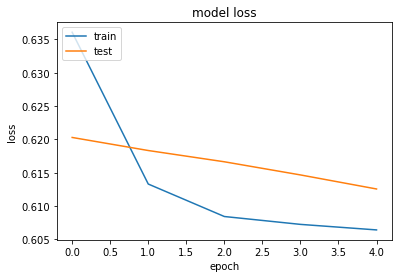

In [8]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


show top 10 movies

In [9]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)


Showing recommendations for user: 488
Movies with high ratings from user
--------------------------------
Shawshank Redemption, The (1994) : Crime|Drama
Some Like It Hot (1959) : Comedy|Crime
Lord of the Rings: The Two Towers, The (2002) : Adventure|Fantasy
Finding Nemo (2003) : Adventure|Animation|Children|Comedy
Whale Rider (2002) : Drama
--------------------------------
Top 10 movie recommendations
--------------------------------
Usual Suspects, The (1995) : Crime|Mystery|Thriller
Star Wars: Episode IV - A New Hope (1977) : Action|Adventure|Sci-Fi
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
Forrest Gump (1994) : Comedy|Drama|Romance|War
Godfather, The (1972) : Crime|Drama
Apocalypse Now (1979) : Action|Drama|War
Star Wars: Episode VI - Return of the Jedi (1983) : Action|Adventure|Sci-Fi
Goodfellas (1990) : Crime|Drama
Godfather: Part II, The (1974) : Crime|Drama
Fight Club (1999) : Action|Crime|Drama|Thriller


Transformer-Based Recommendation System ([Behavior Sequence Transformer (BST)](https://arxiv.org/abs/1905.06874))

In [14]:
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-1m.zip", "movielens.zip")
ZipFile("movielens.zip", "r").extractall()

Load the data into pandas DataFrames with their proper column names.

In [19]:
users = pd.read_csv(
    "ml-1m/users.dat",
    sep="::",
    names=["user_id", "sex", "age_group", "occupation", "zip_code"],
    engine='python'
)

ratings = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "unix_timestamp"],
    engine='python'
)

movies = pd.read_csv(
    "ml-1m/movies.dat", sep="::", names=["movie_id", "title", "genres"],
    engine='python'
)

Do some simple data processing to fix the data types of the columns.

In [20]:
users["user_id"] = users["user_id"].apply(lambda x: f"user_{x}")
users["age_group"] = users["age_group"].apply(lambda x: f"group_{x}")
users["occupation"] = users["occupation"].apply(lambda x: f"occupation_{x}")

movies["movie_id"] = movies["movie_id"].apply(lambda x: f"movie_{x}")

ratings["movie_id"] = ratings["movie_id"].apply(lambda x: f"movie_{x}")
ratings["user_id"] = ratings["user_id"].apply(lambda x: f"user_{x}")
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

Each movie has multiple genres. We split them into separate columns in the movies DataFrame.

In [21]:
genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children's",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]

for genre in genres:
    movies[genre] = movies["genres"].apply(
        lambda values: int(genre in values.split("|"))
    )


Transform the movie ratings data into sequences

In [22]:
ratings_group = ratings.sort_values(by=["unix_timestamp"]).groupby("user_id")

ratings_data = pd.DataFrame(
    data={
        "user_id": list(ratings_group.groups.keys()),
        "movie_ids": list(ratings_group.movie_id.apply(list)),
        "ratings": list(ratings_group.rating.apply(list)),
        "timestamps": list(ratings_group.unix_timestamp.apply(list)),
    }
)


Now, let's split the movie_ids list into a set of sequences of a fixed length. We do the same for the ratings. Set the sequence_length variable to change the length of the input sequence to the model. You can also change the step_size to control the number of sequences to generate for each user.

In [23]:
sequence_length = 4
step_size = 2


def create_sequences(values, window_size, step_size):
    sequences = []
    start_index = 0
    while True:
        end_index = start_index + window_size
        seq = values[start_index:end_index]
        if len(seq) < window_size:
            seq = values[-window_size:]
            if len(seq) == window_size:
                sequences.append(seq)
            break
        sequences.append(seq)
        start_index += step_size
    return sequences


ratings_data.movie_ids = ratings_data.movie_ids.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

ratings_data.ratings = ratings_data.ratings.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

del ratings_data["timestamps"]

After that, we process the output to have each sequence in a separate records in the DataFrame. In addition, we join the user features with the ratings data.

In [24]:
ratings_data_movies = ratings_data[["user_id", "movie_ids"]].explode(
    "movie_ids", ignore_index=True
)
ratings_data_rating = ratings_data[["ratings"]].explode("ratings", ignore_index=True)
ratings_data_transformed = pd.concat([ratings_data_movies, ratings_data_rating], axis=1)
ratings_data_transformed = ratings_data_transformed.join(
    users.set_index("user_id"), on="user_id"
)
ratings_data_transformed.movie_ids = ratings_data_transformed.movie_ids.apply(
    lambda x: ",".join(x)
)
ratings_data_transformed.ratings = ratings_data_transformed.ratings.apply(
    lambda x: ",".join([str(v) for v in x])
)

del ratings_data_transformed["zip_code"]

ratings_data_transformed.rename(
    columns={"movie_ids": "sequence_movie_ids", "ratings": "sequence_ratings"},
    inplace=True,
)

With sequence_length of 4 and step_size of 2, we end up with 498,623 sequences.

Finally, we split the data into training and testing splits, with 85% and 15% of the instances, respectively, and store them to CSV files.

In [25]:
random_selection = np.random.rand(len(ratings_data_transformed.index)) <= 0.85
train_data = ratings_data_transformed[random_selection]
test_data = ratings_data_transformed[~random_selection]

train_data.to_csv("train_data.csv", index=False, sep="|", header=False)
test_data.to_csv("test_data.csv", index=False, sep="|", header=False)

Define metadata

In [26]:
CSV_HEADER = list(ratings_data_transformed.columns)

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "user_id": list(users.user_id.unique()),
    "movie_id": list(movies.movie_id.unique()),
    "sex": list(users.sex.unique()),
    "age_group": list(users.age_group.unique()),
    "occupation": list(users.occupation.unique()),
}

USER_FEATURES = ["sex", "age_group", "occupation"]

MOVIE_FEATURES = ["genres"]

Create tf.data.Dataset for training and evaluation

In [27]:

def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):
    def process(features):
        movie_ids_string = features["sequence_movie_ids"]
        sequence_movie_ids = tf.strings.split(movie_ids_string, ",").to_tensor()

        # The last movie id in the sequence is the target movie.
        features["target_movie_id"] = sequence_movie_ids[:, -1]
        features["sequence_movie_ids"] = sequence_movie_ids[:, :-1]

        ratings_string = features["sequence_ratings"]
        sequence_ratings = tf.strings.to_number(
            tf.strings.split(ratings_string, ","), tf.dtypes.float32
        ).to_tensor()

        # The last rating in the sequence is the target for the model to predict.
        target = sequence_ratings[:, -1]
        features["sequence_ratings"] = sequence_ratings[:, :-1]

        return features, target

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        num_epochs=1,
        header=False,
        field_delim="|",
        shuffle=shuffle,
    ).map(process)

    return dataset


Create model inputs

In [28]:
def create_model_inputs():
    return {
        "user_id": layers.Input(name="user_id", shape=(1,), dtype=tf.string),
        "sequence_movie_ids": layers.Input(
            name="sequence_movie_ids", shape=(sequence_length - 1,), dtype=tf.string
        ),
        "target_movie_id": layers.Input(
            name="target_movie_id", shape=(1,), dtype=tf.string
        ),
        "sequence_ratings": layers.Input(
            name="sequence_ratings", shape=(sequence_length - 1,), dtype=tf.float32
        ),
        "sex": layers.Input(name="sex", shape=(1,), dtype=tf.string),
        "age_group": layers.Input(name="age_group", shape=(1,), dtype=tf.string),
        "occupation": layers.Input(name="occupation", shape=(1,), dtype=tf.string),
    }


Encode input features

The encode_input_features method works as follows:

- Each categorical user feature is encoded using layers.Embedding, with embedding dimension equals to the square root of the vocabulary size of the feature. The embeddings of these features are concatenated to form a single input tensor.
- Each movie in the movie sequence and the target movie is encoded layers.Embedding, where the dimension size is the square root of the number of movies.
- A multi-hot genres vector for each movie is concatenated with its embedding vector, and processed using a non-linear layers.Dense to output a vector of the same movie embedding dimensions.
- A positional embedding is added to each movie embedding in the sequence, and then multiplied by its rating from the ratings sequence.
- The target movie embedding is concatenated to the sequence movie embeddings, producing a tensor with the shape of [batch size, sequence length, embedding size], as expected by the attention layer for the transformer architecture.
- The method returns a tuple of two elements: encoded_transformer_features and encoded_other_features.

In [32]:
def encode_input_features(
    inputs,
    include_user_id=True,
    include_user_features=True,
    include_movie_features=True,
):

    encoded_transformer_features = []
    encoded_other_features = []

    other_feature_names = []
    if include_user_id:
        other_feature_names.append("user_id")
    if include_user_features:
        other_feature_names.extend(USER_FEATURES)

    ## Encode user features
    for feature_name in other_feature_names:
        # Convert the string input values into integer indices.
        vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
        idx = layers.experimental.preprocessing.StringLookup(vocabulary=vocabulary, mask_token=None, num_oov_indices=0)(
            inputs[feature_name]
        )
        # Compute embedding dimensions
        embedding_dims = int(math.sqrt(len(vocabulary)))
        # Create an embedding layer with the specified dimensions.
        embedding_encoder = layers.Embedding(
            input_dim=len(vocabulary),
            output_dim=embedding_dims,
            name=f"{feature_name}_embedding",
        )
        # Convert the index values to embedding representations.
        encoded_other_features.append(embedding_encoder(idx))

    ## Create a single embedding vector for the user features
    if len(encoded_other_features) > 1:
        encoded_other_features = layers.concatenate(encoded_other_features)
    elif len(encoded_other_features) == 1:
        encoded_other_features = encoded_other_features[0]
    else:
        encoded_other_features = None

    ## Create a movie embedding encoder
    movie_vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY["movie_id"]
    movie_embedding_dims = int(math.sqrt(len(movie_vocabulary)))
    # Create a lookup to convert string values to integer indices.
    movie_index_lookup = layers.experimental.preprocessing.StringLookup(
        vocabulary=movie_vocabulary,
        mask_token=None,
        num_oov_indices=0,
        name="movie_index_lookup",
    )
    # Create an embedding layer with the specified dimensions.
    movie_embedding_encoder = layers.Embedding(
        input_dim=len(movie_vocabulary),
        output_dim=movie_embedding_dims,
        name=f"movie_embedding",
    )
    # Create a vector lookup for movie genres.
    genre_vectors = movies[genres].to_numpy()
    movie_genres_lookup = layers.Embedding(
        input_dim=genre_vectors.shape[0],
        output_dim=genre_vectors.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(genre_vectors),
        trainable=False,
        name="genres_vector",
    )
    # Create a processing layer for genres.
    movie_embedding_processor = layers.Dense(
        units=movie_embedding_dims,
        activation="relu",
        name="process_movie_embedding_with_genres",
    )

    ## Define a function to encode a given movie id.
    def encode_movie(movie_id):
        # Convert the string input values into integer indices.
        movie_idx = movie_index_lookup(movie_id)
        movie_embedding = movie_embedding_encoder(movie_idx)
        encoded_movie = movie_embedding
        if include_movie_features:
            movie_genres_vector = movie_genres_lookup(movie_idx)
            encoded_movie = movie_embedding_processor(
                layers.concatenate([movie_embedding, movie_genres_vector])
            )
        return encoded_movie

    ## Encoding target_movie_id
    target_movie_id = inputs["target_movie_id"]
    encoded_target_movie = encode_movie(target_movie_id)

    ## Encoding sequence movie_ids.
    sequence_movies_ids = inputs["sequence_movie_ids"]
    encoded_sequence_movies = encode_movie(sequence_movies_ids)
    # Create positional embedding.
    position_embedding_encoder = layers.Embedding(
        input_dim=sequence_length,
        output_dim=movie_embedding_dims,
        name="position_embedding",
    )
    positions = tf.range(start=0, limit=sequence_length - 1, delta=1)
    encodded_positions = position_embedding_encoder(positions)
    # Retrieve sequence ratings to incorporate them into the encoding of the movie.
    sequence_ratings = tf.expand_dims(inputs["sequence_ratings"], -1)
    # Add the positional encoding to the movie encodings and multiply them by rating.
    encoded_sequence_movies_with_poistion_and_rating = layers.Multiply()(
        [(encoded_sequence_movies + encodded_positions), sequence_ratings]
    )

    # Construct the transformer inputs.
    for encoded_movie in tf.unstack(
        encoded_sequence_movies_with_poistion_and_rating, axis=1
    ):
        encoded_transformer_features.append(tf.expand_dims(encoded_movie, 1))
    encoded_transformer_features.append(encoded_target_movie)

    encoded_transformer_features = layers.concatenate(
        encoded_transformer_features, axis=1
    )

    return encoded_transformer_features, encoded_other_features


Create a BST model

In [33]:
include_user_id = False
include_user_features = False
include_movie_features = False

hidden_units = [256, 128]
dropout_rate = 0.1
num_heads = 3


def create_model():
    inputs = create_model_inputs()
    transformer_features, other_features = encode_input_features(
        inputs, include_user_id, include_user_features, include_movie_features
    )

    # Create a multi-headed attention layer.
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=transformer_features.shape[2], dropout=dropout_rate
    )(transformer_features, transformer_features)

    # Transformer block.
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    x1 = layers.Add()([transformer_features, attention_output])
    x1 = layers.LayerNormalization()(x1)
    x2 = layers.LeakyReLU()(x1)
    x2 = layers.Dense(units=x2.shape[-1])(x2)
    x2 = layers.Dropout(dropout_rate)(x2)
    transformer_features = layers.Add()([x1, x2])
    transformer_features = layers.LayerNormalization()(transformer_features)
    features = layers.Flatten()(transformer_features)

    # Included the other features.
    if other_features is not None:
        features = layers.concatenate(
            [features, layers.Reshape([other_features.shape[-1]])(other_features)]
        )

    # Fully-connected layers.
    for num_units in hidden_units:
        features = layers.Dense(num_units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.LeakyReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


model = create_model()

Run training and evaluation experiment

In [34]:
# Compile the model.
model.compile(
    optimizer=keras.optimizers.Adagrad(learning_rate=0.01),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError()],
)

# Read the training data.
train_dataset = get_dataset_from_csv("train_data.csv", shuffle=True, batch_size=265)

# Fit the model with the training data.
model.fit(train_dataset, epochs=5)

# Read the test data.
test_dataset = get_dataset_from_csv("test_data.csv", batch_size=265)

# Evaluate the model on the test data.
_, rmse = model.evaluate(test_dataset, verbose=0)
print(f"Test MAE: {round(rmse, 3)}")

Epoch 1/5
